In [ ]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [2]:
# MSDL connectivity matrices for nilearn connectome

import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

run_num = 3
runs = list(range(1, run_num + 1))

def verify_standard_space(img):
    """Verify image is in 2mm standard space"""
    if img.shape[:3] != (91, 109, 91):
        logging.warning(f"Unexpected shape: {img.shape}")
        return False
    
    vox_size = np.sqrt(np.sum(img.affine[:3, :3] ** 2, axis=0))
    if not np.allclose(vox_size, [2., 2., 2.], atol=0.1):
        logging.warning(f"Unexpected voxel size: {vox_size}")
        return False
    
    return True

def create_connectivity_matrix(ss):
    """Create connectivity matrix using MSDL atlas"""
    logging.info(f"Processing subject: {ss}")
    
    # Load MSDL atlas
    atlas = datasets.fetch_atlas_msdl()
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load standard space data
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Standard space data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Verify standard space
        if not verify_standard_space(subject_img):
            logging.warning(f"Data not in expected standard space for {ss} run-{rn}")
            continue
        
        # Extract time series using the MSDL atlas
        masker = NiftiMapsMasker(
            maps_img=atlas_img,
            standardize=True,
            memory='nilearn_cache',
            verbose=0
        )
        
        time_series = masker.fit_transform(subject_img)
        all_runs_data.append(time_series)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    # Create output directory if it doesn't exist
    output_dir = f'{results_dir}/connectivity_matrices_MSDL'
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each subject
    for ss in subs:
        try:
            connectivity_matrix = create_connectivity_matrix(ss)
            if connectivity_matrix is not None:
                output_path = f'{output_dir}/{ss}_connectivity_matrix_MSDL.npy'
                np.save(output_path, connectivity_matrix)
                logging.info(f'Saved MSDL connectivity matrix for {ss} at {output_path}')
                logging.info(f'Matrix shape: {connectivity_matrix.shape}')  # Should be (39, 39) for MSDL
        except Exception as e:
            logging.error(f"Error processing subject {ss}: {str(e)}")
            continue

if __name__ == "__main__":
    main()

2024-11-12 10:42:17,969 - INFO - Processing subject: sub-025
2024-11-12 10:43:30,586 - INFO - Saved MSDL connectivity matrix for sub-025 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-025_connectivity_matrix_MSDL.npy
2024-11-12 10:43:30,588 - INFO - Matrix shape: (39, 39)
2024-11-12 10:43:30,589 - INFO - Processing subject: sub-038
2024-11-12 10:44:29,157 - INFO - Saved MSDL connectivity matrix for sub-038 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-038_connectivity_matrix_MSDL.npy
2024-11-12 10:44:29,159 - INFO - Matrix shape: (39, 39)
2024-11-12 10:44:29,160 - INFO - Processing subject: sub-057
2024-11-12 10:45:30,171 - INFO - Saved MSDL connectivity matrix for sub-057 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-057_connectivity_matrix_MSDL.npy
2024-11-12 10:45:30,173 - INFO - Matrix shape: (39, 39)
2024-11-12 10:45:30,174 - INFO - Processing subject: sub-059
2024-11-12 10:46:31,143 - INFO

2024-11-12 11:10:40,291 - INFO - Loaded matrix for subject sub-025
2024-11-12 11:10:40,294 - INFO - Loaded matrix for subject sub-038
2024-11-12 11:10:40,296 - INFO - Loaded matrix for subject sub-057
2024-11-12 11:10:40,299 - INFO - Loaded matrix for subject sub-059


2024-11-12 11:10:40,302 - INFO - Loaded matrix for subject sub-064
2024-11-12 11:10:40,304 - INFO - Loaded matrix for subject sub-067
2024-11-12 11:10:40,307 - INFO - Loaded matrix for subject sub-068
2024-11-12 11:10:40,309 - INFO - Loaded matrix for subject sub-071
2024-11-12 11:10:40,312 - INFO - Loaded matrix for subject sub-083
2024-11-12 11:10:40,314 - INFO - Loaded matrix for subject sub-084
2024-11-12 11:10:40,317 - INFO - Loaded matrix for subject sub-085
2024-11-12 11:10:40,320 - INFO - Loaded matrix for subject sub-087
2024-11-12 11:10:40,322 - INFO - Loaded matrix for subject sub-088
2024-11-12 11:10:40,325 - INFO - Loaded matrix for subject sub-093
2024-11-12 11:10:40,327 - INFO - Loaded matrix for subject sub-094
2024-11-12 11:10:40,330 - INFO - Loaded matrix for subject sub-095
2024-11-12 11:10:40,332 - INFO - Loaded matrix for subject sub-096
2024-11-12 11:10:40,334 - INFO - Loaded matrix for subject sub-097
2024-11-12 11:10:40,337 - INFO - Loaded matrix for subject sub

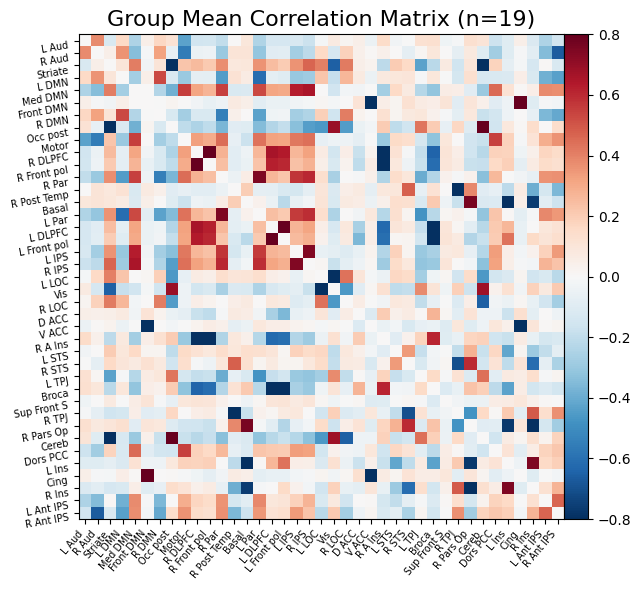

<Figure size 800x600 with 0 Axes>

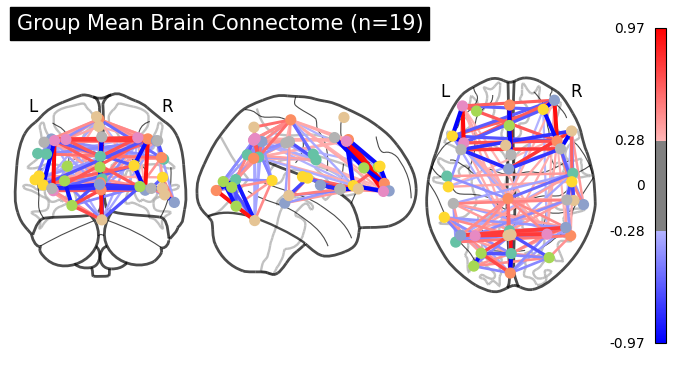


Group-Level Connectivity Statistics:
Number of subjects: 19
Shape: (39, 39)
Value range: [-0.966, 1.000]
Number of regions: 39


In [5]:
# MSDL connectivity visuals for nilearn connectome
import os
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load subject information
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix_dir = f'{results_dir}/connectivity_matrices_MSDL'

# Load MSDL atlas for labels and coordinates
atlas = datasets.fetch_atlas_msdl()
labels = atlas.labels
coords = atlas.region_coords

def load_all_matrices():
    """Load and average matrices across all subjects"""
    all_matrices = []
    
    for sub in subs:
        matrix_path = f'{matrix_dir}/{sub}_connectivity_matrix_MSDL.npy'
        if os.path.exists(matrix_path):
            try:
                matrix = np.load(matrix_path)
                all_matrices.append(matrix)
                logging.info(f"Loaded matrix for subject {sub}")
            except Exception as e:
                logging.error(f"Error loading matrix for {sub}: {str(e)}")
    
    if not all_matrices:
        raise ValueError("No matrices were successfully loaded")
    
    # Calculate mean and standard deviation across subjects
    mean_matrix = np.mean(all_matrices, axis=0)
    std_matrix = np.std(all_matrices, axis=0)
    
    return mean_matrix, std_matrix, len(all_matrices)

def create_group_visualizations(mean_matrix, std_matrix, n_subjects):
    """Create group-level visualizations"""
    # Plot 1: Correlation Matrix
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = plt.subplot(121)
    matrix_plot = mean_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    plotting.plot_matrix(
        matrix_plot,
        labels=labels,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title=f'Group Mean Correlation Matrix (n={n_subjects})',
        axes=ax1
    )
    
    # Plot 2: Brain Connectome as separate figure
    fig_connectome = plt.figure(figsize=(8, 6))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="80%",
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome (n={n_subjects})',
        display_mode='ortho'
    )
    
    # Show both plots
    plt.show()
    
    # Create interactive 3D view
    view = plotting.view_connectome(
        mean_matrix,
        coords,
        edge_threshold="0%"
    )
    #view.open_in_browser()
    
    # Print connectivity statistics
    print("\nGroup-Level Connectivity Statistics:")
    print(f"Number of subjects: {n_subjects}")
    print(f"Shape: {mean_matrix.shape}")
    print(f"Value range: [{mean_matrix.min():.3f}, {mean_matrix.max():.3f}]")
    print(f"Number of regions: {len(labels)}")

def main():
    try:
        # Load and average all matrices
        mean_matrix, std_matrix, n_subjects = load_all_matrices()
        
        # Create group-level visualizations
        create_group_visualizations(mean_matrix, std_matrix, n_subjects)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

2024-11-12 11:17:04,761 - INFO - Loaded matrix for subject sub-025
2024-11-12 11:17:04,764 - INFO - Loaded matrix for subject sub-038
2024-11-12 11:17:04,766 - INFO - Loaded matrix for subject sub-057
2024-11-12 11:17:04,768 - INFO - Loaded matrix for subject sub-059
2024-11-12 11:17:04,769 - INFO - Loaded matrix for subject sub-064
2024-11-12 11:17:04,772 - INFO - Loaded matrix for subject sub-067
2024-11-12 11:17:04,774 - INFO - Loaded matrix for subject sub-068
2024-11-12 11:17:04,776 - INFO - Loaded matrix for subject sub-071
2024-11-12 11:17:04,777 - INFO - Loaded matrix for subject sub-083
2024-11-12 11:17:04,780 - INFO - Loaded matrix for subject sub-084
2024-11-12 11:17:04,782 - INFO - Loaded matrix for subject sub-085
2024-11-12 11:17:04,784 - INFO - Loaded matrix for subject sub-087
2024-11-12 11:17:04,786 - INFO - Loaded matrix for subject sub-088
2024-11-12 11:17:04,788 - INFO - Loaded matrix for subject sub-093
2024-11-12 11:17:04,790 - INFO - Loaded matrix for subject sub


Group-Level Connectivity Statistics:
Number of subjects: 19
Matrix shape: (39, 39)
Mean correlation range: [-0.966, 1.000]
Standard deviation range: [0.000, 0.423]

ROI-specific connections:
L LOC <-> R LOC: 0.431 ± 0.200
L LOC <-> L IPS: -0.057 ± 0.423
L LOC <-> R IPS: 0.014 ± 0.354
L LOC <-> L Ant IPS: -0.122 ± 0.225
L LOC <-> R Ant IPS: -0.214 ± 0.221
R LOC <-> L IPS: -0.104 ± 0.299
R LOC <-> R IPS: -0.080 ± 0.396
R LOC <-> L Ant IPS: -0.154 ± 0.212
R LOC <-> R Ant IPS: -0.270 ± 0.215
L IPS <-> R IPS: 0.743 ± 0.110
L IPS <-> L Ant IPS: 0.183 ± 0.204
L IPS <-> R Ant IPS: 0.342 ± 0.180
R IPS <-> L Ant IPS: 0.274 ± 0.181
R IPS <-> R Ant IPS: 0.228 ± 0.246
L Ant IPS <-> R Ant IPS: 0.468 ± 0.194


<Figure size 640x480 with 0 Axes>

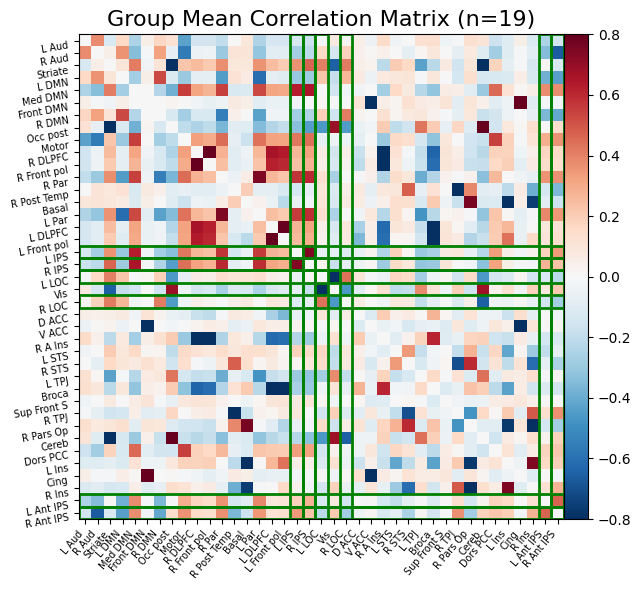

<Figure size 800x800 with 0 Axes>

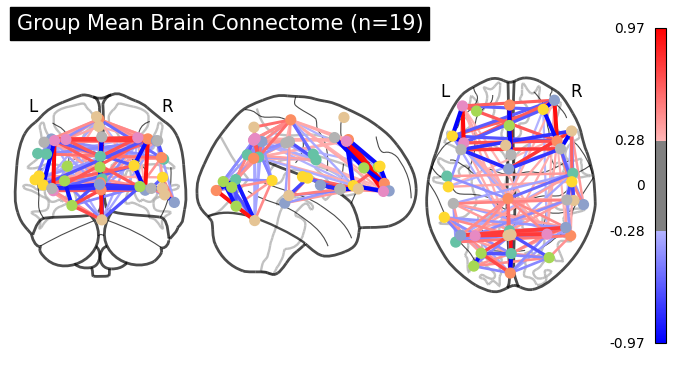

In [10]:
#highlight roi
import os
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load subject information
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix_dir = f'{results_dir}/connectivity_matrices_MSDL'

# Load MSDL atlas for labels and coordinates
atlas = datasets.fetch_atlas_msdl()
labels = atlas.labels
coords = atlas.region_coords

def create_group_visualizations(mean_matrix, std_matrix, n_subjects):
    
    """Create group-level visualizations with highlighted ROIs"""
    # Explicitly create a new figure
    plt.clf()  # Clear any existing figures
    fig = plt.figure(figsize=(15, 6))
    
    # Plot 1: Mean Correlation Matrix
    ax1 = plt.subplot(121)
    matrix_plot = mean_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    # Create ROI indices with correct MSDL atlas labels
    roi_names = ['L LOC', 'R LOC', 'L IPS', 'R IPS', 'L Ant IPS', 'R Ant IPS']
    roi_indices = [labels.index(roi) for roi in roi_names]
    
    # Plot the matrix
    plotting.plot_matrix(
        matrix_plot,
        labels=labels,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title=f'Group Mean Correlation Matrix (n={n_subjects})',
        axes=ax1
    )
    
    # Add highlighting for ROIs
    n_labels = len(labels)
    for idx in roi_indices:
        # Highlight row
        ax1.add_patch(plt.Rectangle((-0.5, idx - 0.5), n_labels, 1, 
                                  fill=False, edgecolor='green', lw=2))
        # Highlight column
        ax1.add_patch(plt.Rectangle((idx - 0.5, -0.5), 1, n_labels, 
                                  fill=False, edgecolor='green', lw=2))
    
    # Save the correlation matrix plot
    #plt.savefig(f'{results_dir}/msdl_correlation_matrix_highlighted.png', 
                #dpi=300, bbox_inches='tight')
    
    # Create a new figure for the connectome
    plt.figure(figsize=(8, 8))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="80%",
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome (n={n_subjects})'
    )
    
    # Save the connectome plot
    #plt.savefig(f'{results_dir}/msdl_connectome.png', 
                #dpi=300, bbox_inches='tight')
    
    # Close all figures to free memory
    #plt.close('all')
    
    # Create interactive 3D view
    view = plotting.view_connectome(
        mean_matrix,
        coords,
        edge_threshold="80%"
    )
    #view.open_in_browser()
    
    # Print group-level statistics
    print("\nGroup-Level Connectivity Statistics:")
    print(f"Number of subjects: {n_subjects}")
    print(f"Matrix shape: {mean_matrix.shape}")
    print(f"Mean correlation range: [{mean_matrix.min():.3f}, {mean_matrix.max():.3f}]")
    print(f"Standard deviation range: [{std_matrix.min():.3f}, {std_matrix.max():.3f}]")
    
    # Add specific analysis of ROI connections
    print("\nROI-specific connections:")
    for i, roi1 in enumerate(roi_names):
        idx1 = labels.index(roi1)
        for roi2 in roi_names[i+1:]:
            idx2 = labels.index(roi2)
            correlation = mean_matrix[idx1, idx2]
            std = std_matrix[idx1, idx2]
            print(f"{roi1} <-> {roi2}: {correlation:.3f} ± {std:.3f}")\

def main():
    try:
        # Load and average all matrices
        mean_matrix, std_matrix, n_subjects = load_all_matrices()
        
        # Create group-level visualizations
        create_group_visualizations(mean_matrix, std_matrix, n_subjects)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

In [11]:
#  creating matrices for group sparse covariance

import os
import numpy as np
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from sklearn.covariance import GraphicalLassoCV
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Directories and paths from your original setup
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

raw_dir = params.raw_dir  # From your original setup
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix_dir = f'{results_dir}/connectivity_matrices_MSDL'

# Load MSDL atlas
atlas = datasets.fetch_atlas_msdl()

def extract_time_series(subject):
    """Extract time series data for a subject using MSDL atlas"""
    all_runs_data = []
    
    for run in range(1, 4):  # 3 runs as in your original code
        run_path = f'{raw_dir}/{subject}/ses-01/derivatives/fsl/loc/run-0{run}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
        
        if not os.path.exists(run_path):
            logging.warning(f'Standard space data not found: {run_path}')
            continue
            
        # Extract time series using the MSDL atlas
        masker = NiftiMapsMasker(
            maps_img=atlas.maps,
            standardize=True,
            memory='nilearn_cache',
            verbose=0
        )
        
        time_series = masker.fit_transform(run_path)
        all_runs_data.append(time_series)
    
    if not all_runs_data:
        return None
    
    # Concatenate all runs
    return np.concatenate(all_runs_data, axis=0)

def estimate_group_sparse_covariance():
    """Estimate group sparse covariance using GraphicalLassoCV"""
    all_subjects_data = []
    processed_subjects = []
    
    # Extract time series for all subjects
    for subject in subs:
        logging.info(f"Processing time series for subject {subject}")
        time_series = extract_time_series(subject)
        
        if time_series is not None:
            all_subjects_data.append(time_series)
            processed_subjects.append(subject)
    
    if not all_subjects_data:
        raise ValueError("No valid time series data found")
    
    # Estimate sparse inverse covariance for each subject
    sparse_covariances = []
    sparse_precisions = []
    
    for idx, (subject, time_series) in enumerate(zip(processed_subjects, all_subjects_data)):
        logging.info(f"Estimating sparse covariance for subject {subject} ({idx+1}/{len(processed_subjects)})")
        
        # Use GraphicalLassoCV to automatically set sparsity
        gl = GraphicalLassoCV(verbose=1, n_jobs=-1)  # Use all available cores
        gl.fit(time_series)
        
        # Store both covariance and precision matrices
        sparse_covariances.append(gl.covariance_)
        sparse_precisions.append(gl.precision_)
        
        # Save individual subject matrices
        np.save(f'{matrix_dir}/{subject}_sparse_covariance_MSDL.npy', gl.covariance_)
        np.save(f'{matrix_dir}/{subject}_sparse_precision_MSDL.npy', gl.precision_)
    
    # Calculate and save group average matrices
    mean_sparse_covariance = np.mean(sparse_covariances, axis=0)
    mean_sparse_precision = np.mean(sparse_precisions, axis=0)
    
    np.save(f'{matrix_dir}/group_mean_sparse_covariance_MSDL.npy', mean_sparse_covariance)
    np.save(f'{matrix_dir}/group_mean_sparse_precision_MSDL.npy', mean_sparse_precision)
    
    logging.info(f"Processed {len(processed_subjects)} subjects successfully")
    return mean_sparse_covariance, mean_sparse_precision, processed_subjects

def main():
    try:
        # Estimate group sparse covariance
        mean_covariance, mean_precision, processed_subjects = estimate_group_sparse_covariance()
        
        logging.info("Group sparse estimation completed successfully")
        logging.info(f"Number of subjects processed: {len(processed_subjects)}")
        logging.info(f"Covariance matrix shape: {mean_covariance.shape}")
        
        # Save list of processed subjects
        with open(f'{matrix_dir}/processed_subjects_sparse.txt', 'w') as f:
            f.write('\n'.join(processed_subjects))
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

2024-11-12 11:24:51,591 - INFO - Processing time series for subject sub-025
2024-11-12 11:26:32,874 - INFO - Processing time series for subject sub-038
2024-11-12 11:28:12,133 - INFO - Processing time series for subject sub-057
2024-11-12 11:29:54,914 - INFO - Processing time series for subject sub-059
2024-11-12 11:31:32,024 - INFO - Processing time series for subject sub-064
2024-11-12 11:33:03,239 - INFO - Processing time series for subject sub-067
2024-11-12 11:34:38,650 - INFO - Processing time series for subject sub-068
2024-11-12 11:36:16,905 - INFO - Processing time series for subject sub-071
2024-11-12 11:37:57,104 - INFO - Processing time series for subject sub-083
2024-11-12 11:39:38,832 - INFO - Processing time series for subject sub-084
2024-11-12 11:41:10,925 - INFO - Processing time series for subject sub-085
2024-11-12 11:42:49,419 - INFO - Processing time series for subject sub-087
2024-11-12 11:44:26,754 - INFO - Processing time series for subject sub-088
2024-11-12 1

[GraphicalLassoCV] Done refinement  1 out of 4:   5s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007565917997656157, tolerance: 0.00033891907026187767
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036999319795505414, tolerance: 0.0003205036254867427
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011241254066618467, tolerance: 0.0005724450967359876
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(

[GraphicalLassoCV] Done refinement  2 out of 4:   6s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00103166054062509, tolerance: 0.0006480084568495151
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007739125700787497, tolerance: 0.0005765268615338435
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -1.402e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceW

[GraphicalLassoCV] Done refinement  3 out of 4:   7s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 3.198e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009300833784662288, tolerance: 0.0005696231587274544
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00090678505840458, tolerance: 0.0005160168466396355
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWa

[GraphicalLassoCV] Done refinement  4 out of 4:   7s


2024-11-12 11:55:58,185 - INFO - Estimating sparse covariance for subject sub-038 (2/19)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11921124676755523, tolerance: 0.0003675319419262014
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027363529932332598, tolerance: 0.000480345928929034
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to 

[GraphicalLassoCV] Done refinement  1 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 2.703e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.069e-04
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003847563674939103, tolerance: 0.00018524037723915138
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance

[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006805732808805587, tolerance: 0.000552442487362337
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001799558703859283, tolerance: 0.0007221986044684082
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000859723646499333, tolerance: 0.0005859071122871818
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/hom

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -1.856e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -6.334e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012200462013982616, tolerance: 0.0004708555819075259
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000546462

[GraphicalLassoCV] Done refinement  4 out of 4:   0s
[GraphicalLassoCV] Done refinement  1 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026373836822290997, tolerance: 0.00024177401251335924
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016366815546620117, tolerance: 0.000594554077112342
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010452744797011526, tolerance: 0.00038560291210429717
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(

[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 7.231e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015932100314053343, tolerance: 0.0005220970124294494
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005785393958221974, tolerance: 0.000493186481727079
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceW

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 3.835e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001891211428569406, tolerance: 0.0005684197506075686
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005549504680599782, tolerance: 0.0005179129676259845
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceW

[GraphicalLassoCV] Done refinement  4 out of 4:   0s
[GraphicalLassoCV] Done refinement  1 out of 4:   0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006640347471367214, tolerance: 0.0002550948820436342
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013478069770829215, tolerance: 0.0003080673737312057
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the n

[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -5.758e-04
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001568957552419814, tolerance: 0.0003718291709767912
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006512501801614334, tolerance: 0.0005832046973379382
  coefs, _, _, _ = cd_fast

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -1.632e-04
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


[GraphicalLassoCV] Done refinement  4 out of 4:   0s


2024-11-12 11:56:01,623 - INFO - Estimating sparse covariance for subject sub-064 (5/19)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0004805832802917212
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0004243935429550004
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000557018506202489, tolerance: 0.0003600524049120722
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008239704194283881, tolerance: 0.00041894203612637544
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005637883994626947, tolerance: 0.00046895239661817875
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.646e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.863e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -1.476e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001005140933648896, tolerance: 0.0005881896622979165
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/a

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


2024-11-12 11:56:02,839 - INFO - Estimating sparse covariance for subject sub-067 (6/19)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0003276774023216764
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0005016434657589539
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

[GraphicalLassoCV] Done refinement  1 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022200920754738007, tolerance: 0.0011027425809328592
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014328550666391493, tolerance: 0.0013511070393279585
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019230765721420795, tolerance: 0.0013493864116889914
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/

[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026119302623133223, tolerance: 0.0010937539631623767
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -1.249e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 9.850e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012283589

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001099494081262975, tolerance: 0.0010420058619594723
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015101301274231815, tolerance: 0.0010937539631623767
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003120496553503216, tolerance: 0.001105590444025214
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/hom

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18221329783329798, tolerance: 0.0004811610076798827
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1306437140988292, tolerance: 0.0004921937258028938
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008962749879420362, tolerance: 0.0004541

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.476e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 4.463e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 2.777e-04
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterat

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005979025281495076, tolerance: 0.00035610263370273554
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015143747697665688, tolerance: 0.0004911365951126873
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000743350916990515, tolerance: 0.0006622678336667987
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1836023656844614, tolerance: 0.0008318376492002065
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21860660490645167, tolerance: 0.0007692314378856522
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0008278856039726535
  co

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013260576656408674, tolerance: 0.0008223442033305056
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001099729919427972, tolerance: 0.0007409231828211656
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008689131892749558, tolerance: 0.0006518850465869867
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/h

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -6.983e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -1.792e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000901612220319592, tolerance: 0.0008187437223355261
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -9.360e-04
  warnings.warn(
/home/csimmon2

[GraphicalLassoCV] Done refinement  4 out of 4:   0s
[GraphicalLassoCV] Done refinement  1 out of 4:   0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009445668800287521, tolerance: 0.0005742807717954798
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009306443412677723, tolerance: 0.0006577397714526219
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008842524824479447, tolerance: 0.0

[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -3.172e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009692980690578779, tolerance: 0.0007570967972234321
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004443341674510215, tolerance: 0.0005742807717954798
  coefs, _, _, _ = cd_fast

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 4.767e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 5.034e-04
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
2024-11-12 11:56:06,677 - INFO - Estimating sparse covariance for subject sub-084 (10/19)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019291622310187773, tolerance: 0.0003955718011069417
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gr

[GraphicalLassoCV] Done refinement  4 out of 4:   0s
[GraphicalLassoCV] Done refinement  1 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.00021670991568401986
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.00038587185081124007
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 3.589e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.620e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 2.386e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007640134574367075, tolerance: 0.00047775223740992
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/ana

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.882e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 4.945e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 3.356e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004914653494005883, tolerance: 0.00047775223740992
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/ana

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2343775655171859, tolerance: 0.00030187253085242773
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7211298129206072, tolerance: 0.0003848081888632208
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.00036654466186677325
  c

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.270e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.108e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.063e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.498e-04
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 conc

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.848e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.681e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.240e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 2.383e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Object

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


2024-11-12 11:56:08,662 - INFO - Estimating sparse covariance for subject sub-087 (12/19)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.00011505362608933492
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0006505683843724147
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.439e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.257e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.701e-04
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterat

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 3.338e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 2.862e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 4.812e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009660149143559948, tolerance: 0.00045577319697923704
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


2024-11-12 11:56:10,285 - INFO - Estimating sparse covariance for subject sub-088 (13/19)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0004350161638614595
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0004170820234100775
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

[GraphicalLassoCV] Done refinement  1 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048662168637481074, tolerance: 0.00047323782297332794
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007187791169585012, tolerance: 0.0005390897084595126
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.209e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: Convergen

[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 1.813e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006898891696724974, tolerance: 0.0005563291542052946
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017813532113741815, tolerance: 0.0006538154660552143
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: Convergence

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017593809929952187, tolerance: 0.0005390897084595126
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008645473525863423, tolerance: 0.0005622100579147515
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014566063252852146, tolerance: 0.0006690578060167462
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


2024-11-12 11:56:11,681 - INFO - Estimating sparse covariance for subject sub-093 (14/19)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16782043514237976, tolerance: 0.00044099917041531627
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0005455828865901357
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the n

[GraphicalLassoCV] Done refinement  1 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 2.242e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012252934852261532, tolerance: 0.0007781582935094469
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011860079704639759, tolerance: 0.0009631481052820306
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: Convergence

[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 3.683e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001226672172196075, tolerance: 0.001010370532631548
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005002973382024933, tolerance: 0.0010508836401233383
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWar

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -9.590e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -1.708e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033500444370924143, tolerance: 0.0008564647072076808
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -7.265e-04
  warnings.warn(
/home/csimmon

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001051931316752075, tolerance: 0.0006378095104186952
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008664559308568798, tolerance: 0.0005479671220262811
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the nu

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009826997363111545, tolerance: 0.0007353489462510755
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008877832019331677, tolerance: 0.0007367245178910236
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007368418389805953, tolerance: 0.0006715416790470671
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 8.463e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007683953689383571, tolerance: 0.000634837998082931
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005596436273958005, tolerance: 0.0005478463344014601
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceW

[GraphicalLassoCV] Done refinement  4 out of 4:   0s
[GraphicalLassoCV] Done refinement  1 out of 4:   0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001639815659435051, tolerance: 0.0008009638758080334
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010462622399542987, tolerance: 0.0002834981542665702
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the nu

[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 3.974e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 6.779e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 5.849e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007076310509486206, tolerance: 0.0006116651132258207
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/a

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 7.044e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -3.694e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005463555108269347, tolerance: 0.0005128743727111473
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007355447

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


2024-11-12 11:56:15,188 - INFO - Estimating sparse covariance for subject sub-096 (17/19)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48278417718704547, tolerance: 0.00040723110865867947
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.00045284611793903134
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the 

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008417255317638705, tolerance: 0.0005711058654284838
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005984386761008764, tolerance: 0.0005487372063794773
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005475785705852942, tolerance: 0.0004734439716257149
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032211322121922237, tolerance: 0.0001211022509422328
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047843803726310696, tolerance: 0.00042582195361621963
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021816273804162734, tolerance: 0.0005390700987875743
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


2024-11-12 11:56:16,403 - INFO - Estimating sparse covariance for subject sub-097 (18/19)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.00043063140900324214
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0006241097442845362
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007013016501851155, tolerance: 0.00063475956324572
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005049881244203913, tolerance: 0.00041816175038296015
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the num

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -4.123e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -6.672e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006013950290633119, tolerance: 0.0005847672369911804
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000636443

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009732856683584146, tolerance: 0.00022845688473735189
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004350398078205586, tolerance: 0.00039203340422732416
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -2.790e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003383627534563338, tolerance: 0.00032637322458203957
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -1.829e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: -2.740e-04
  warnings.warn(
/home/csimmo

[GraphicalLassoCV] Done refinement  3 out of 4:   0s


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 6.193e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 2.531e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 10 iteration: dual gap: 5.703e-04
  warnings.warn(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006073352860918035, tolerance: 0.0004308607105514491
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/csimmon2/a

[GraphicalLassoCV] Done refinement  4 out of 4:   0s


In [12]:
# visuals for sparse covariance
import os
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load MSDL atlas for labels and coordinates
atlas = datasets.fetch_atlas_msdl()
labels = atlas.labels
coords = atlas.region_coords

# Directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix_dir = f'{results_dir}/connectivity_matrices_MSDL'

def load_connectivity_matrices():
    """Load correlation and sparse connectivity matrices"""
    # Load group mean correlation matrix (from your previous analysis)
    corr_matrix = np.load(f'{matrix_dir}/group_mean_sparse_covariance_MSDL.npy')
    prec_matrix = np.load(f'{matrix_dir}/group_mean_sparse_precision_MSDL.npy')
    
    return corr_matrix, prec_matrix

def create_comparison_visualizations(corr_matrix, prec_matrix):
    """Create visualizations comparing different connectivity measures"""
    # Create figure with three subplots
    plt.clf()
    fig = plt.figure(figsize=(20, 6))
    
    # Plot 1: Correlation Matrix
    ax1 = plt.subplot(131)
    matrix_plot = corr_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    # Create ROI indices with correct MSDL atlas labels
    roi_names = ['L LOC', 'R LOC', 'L IPS', 'R IPS', 'L Ant IPS', 'R Ant IPS']
    roi_indices = [labels.index(roi) for roi in roi_names]
    
    plotting.plot_matrix(
        matrix_plot,
        labels=labels,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title='Group Sparse Covariance Matrix',
        axes=ax1
    )
    
    # Add highlighting for ROIs
    n_labels = len(labels)
    for idx in roi_indices:
        # Highlight row
        ax1.add_patch(plt.Rectangle((-0.5, idx - 0.5), n_labels, 1, 
                                  fill=False, edgecolor='green', lw=2))
        # Highlight column
        ax1.add_patch(plt.Rectangle((idx - 0.5, -0.5), 1, n_labels, 
                                  fill=False, edgecolor='green', lw=2))
    
    # Plot 2: Precision Matrix
    ax2 = plt.subplot(132)
    matrix_plot = prec_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    plotting.plot_matrix(
        matrix_plot,
        labels=labels,
        colorbar=True,
        title='Group Sparse Precision Matrix',
        axes=ax2
    )
    
    # Add highlighting for ROIs
    for idx in roi_indices:
        # Highlight row
        ax2.add_patch(plt.Rectangle((-0.5, idx - 0.5), n_labels, 1, 
                                  fill=False, edgecolor='green', lw=2))
        # Highlight column
        ax2.add_patch(plt.Rectangle((idx - 0.5, -0.5), 1, n_labels, 
                                  fill=False, edgecolor='green', lw=2))
    
    # Plot 3: Connectome from Precision Matrix
    ax3 = plt.subplot(133, projection='3d')
    plotting.plot_connectome(
        prec_matrix,
        coords,
        edge_threshold='80%',
        node_color='auto',
        colorbar=True,
        title='Sparse Precision Connectome',
        axes=ax3
    )
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/connectivity_comparison_MSDL.png', 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create interactive 3D views
    view = plotting.view_connectome(
        prec_matrix,
        coords,
        edge_threshold="80%"
    )
    view.save_as_html(f'{results_dir}/sparse_precision_connectome.html')
    
    # Analysis of ROI connections in both matrices
    print("\nROI Connectivity Analysis:")
    print("\nSparse Covariance values between ROIs:")
    for i, roi1 in enumerate(roi_names):
        idx1 = labels.index(roi1)
        for roi2 in roi_names[i+1:]:
            idx2 = labels.index(roi2)
            cov_val = corr_matrix[idx1, idx2]
            prec_val = prec_matrix[idx1, idx2]
            print(f"{roi1} <-> {roi2}:")
            print(f"  Covariance: {cov_val:.3f}")
            print(f"  Precision:  {prec_val:.3f}")
    
    # Save ROI connectivity values to CSV
    roi_connections = []
    for i, roi1 in enumerate(roi_names):
        idx1 = labels.index(roi1)
        for roi2 in roi_names[i+1:]:
            idx2 = labels.index(roi2)
            roi_connections.append({
                'ROI1': roi1,
                'ROI2': roi2,
                'Covariance': corr_matrix[idx1, idx2],
                'Precision': prec_matrix[idx1, idx2]
            })
    
    roi_df = pd.DataFrame(roi_connections)
    roi_df.to_csv(f'{results_dir}/msdl_roi_sparse_connections.csv', index=False)
    
    # Print general statistics
    print("\nGeneral Statistics:")
    print("Sparse Covariance Matrix:")
    print(f"  Range: [{corr_matrix.min():.3f}, {corr_matrix.max():.3f}]")
    print(f"  Mean absolute value: {np.mean(np.abs(corr_matrix)):.3f}")
    print(f"  Sparsity (proportion of zeros): {np.mean(np.abs(corr_matrix) < 1e-10):.3f}")
    
    print("\nSparse Precision Matrix:")
    print(f"  Range: [{prec_matrix.min():.3f}, {prec_matrix.max():.3f}]")
    print(f"  Mean absolute value: {np.mean(np.abs(prec_matrix)):.3f}")
    print(f"  Sparsity (proportion of zeros): {np.mean(np.abs(prec_matrix) < 1e-10):.3f}")

def main():
    try:
        # Load matrices
        corr_matrix, prec_matrix = load_connectivity_matrices()
        
        # Create visualizations
        create_comparison_visualizations(corr_matrix, prec_matrix)
        
        logging.info("Visualization and analysis completed successfully")
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

2024-11-12 11:56:24,670 - INFO - Visualization and analysis completed successfully



ROI Connectivity Analysis:

Sparse Covariance values between ROIs:
L LOC <-> R LOC:
  Covariance: 0.276
  Precision:  -0.073
L LOC <-> L IPS:
  Covariance: -0.022
  Precision:  0.127
L LOC <-> R IPS:
  Covariance: 0.046
  Precision:  0.009
L LOC <-> L Ant IPS:
  Covariance: -0.045
  Precision:  0.025
L LOC <-> R Ant IPS:
  Covariance: -0.100
  Precision:  0.020
R LOC <-> L IPS:
  Covariance: -0.031
  Precision:  0.036
R LOC <-> R IPS:
  Covariance: -0.024
  Precision:  0.129
R LOC <-> L Ant IPS:
  Covariance: -0.058
  Precision:  0.007
R LOC <-> R Ant IPS:
  Covariance: -0.140
  Precision:  0.034
L IPS <-> R IPS:
  Covariance: 0.550
  Precision:  -0.603
L IPS <-> L Ant IPS:
  Covariance: 0.151
  Precision:  -0.001
L IPS <-> R Ant IPS:
  Covariance: 0.195
  Precision:  -0.023
R IPS <-> L Ant IPS:
  Covariance: 0.167
  Precision:  -0.011
R IPS <-> R Ant IPS:
  Covariance: 0.173
  Precision:  -0.030
L Ant IPS <-> R Ant IPS:
  Covariance: 0.289
  Precision:  -0.208

General Statistics:
Sp

<Figure size 640x480 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

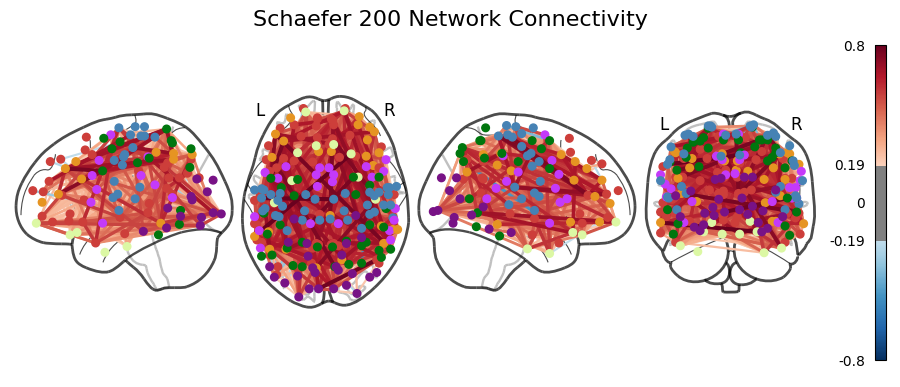

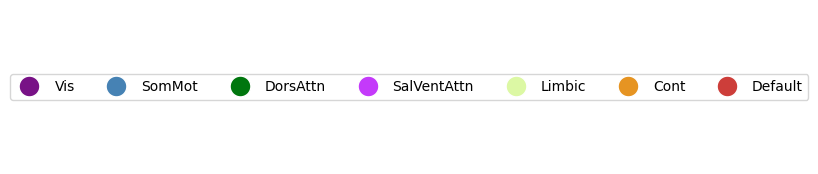


Network Distribution:
Vis: 25 ROIs
SomMot: 37 ROIs
DorsAttn: 31 ROIs
SalVentAttn: 22 ROIs
Limbic: 10 ROIs
Cont: 25 ROIs
Default: 50 ROIs

Connectivity Statistics:
Mean absolute connectivity: 0.061
Max positive connectivity: 0.792
Max negative connectivity: -0.471

Strongest Positive Connections:
7networks_RH_DorsAttn_TempOcc_4 <-> 7networks_LH_Vis_Striate_2: 0.776
7networks_RH_Limbic_OFC_2 <-> 7networks_LH_Cont_Temp: 0.791
7networks_LH_Cont_Temp <-> 7networks_RH_Limbic_OFC_2: 0.791
7networks_LH_SomMot_12 <-> 7networks_RH_SomMot_5: 0.792
7networks_RH_SomMot_5 <-> 7networks_LH_SomMot_12: 0.792


In [ ]:
# remapping schaefer 200 atlas to work with nilearn glass brain
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt

# Load your correlation matrix
matrix_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
correlation_matrix = np.load(matrix_path)

# Load coordinates from saved file
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_1mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

# Define network colors (Yeo7 standard colors)
network_colors = {
    'Vis': '#781286',       # Purple
    'SomMot': '#4682B4',    # Blue
    'DorsAttn': '#00760E',  # Green
    'SalVentAttn': '#C43AFA',  # Magenta
    'Limbic': '#DCF8A4',    # Light green/yellow
    'Cont': '#E69422',      # Orange
    'Default': '#CD3E3A'    # Red
}

# Extract network names from ROI names and map to colors
network_names = [name.split('_')[2] for name in coords_df['ROI Name']]
node_colors = [network_colors[network] for network in network_names]

# Create connectome plot
plt.figure(figsize=(20, 10))
display = plotting.plot_connectome(
    correlation_matrix,
    coords,
    edge_threshold='90%',  # Showing more connections for better visualization
    node_size=30,
    node_color=node_colors,
    display_mode='lzry',   # Multiple views
    edge_vmin=-0.8,
    edge_vmax=0.8,
    colorbar=True,
    edge_cmap='RdBu_r'     # Red-Blue colormap for negative-positive correlations
)
plt.suptitle('Schaefer 200 Network Connectivity', fontsize=16, y=1.05)

# Add legend
legend_fig = plt.figure(figsize=(10, 2))
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=network, markersize=15)
                  for network, color in network_colors.items()]
plt.legend(handles=legend_elements, loc='center', ncol=7)
plt.axis('off')
plt.show()

# Print network statistics
print("\nNetwork Distribution:")
for network in network_colors.keys():
    count = sum(1 for name in network_names if name == network)
    print(f"{network}: {count} ROIs")

print("\nConnectivity Statistics:")
np.fill_diagonal(correlation_matrix, 0)  # Remove diagonal for stats
print(f"Mean absolute connectivity: {np.mean(np.abs(correlation_matrix)):.3f}")
print(f"Max positive connectivity: {np.max(correlation_matrix):.3f}")
print(f"Max negative connectivity: {np.min(correlation_matrix):.3f}")

# Show strongest connections
print("\nStrongest Positive Connections:")
top_positive = np.unravel_index(np.argsort(correlation_matrix.ravel())[-5:], correlation_matrix.shape)
for i, j in zip(top_positive[0], top_positive[1]):
    if i != j:  # Skip diagonal
        print(f"{coords_df['ROI Name'][i]} <-> {coords_df['ROI Name'][j]}: {correlation_matrix[i,j]:.3f}")

<Figure size 1000x800 with 0 Axes>

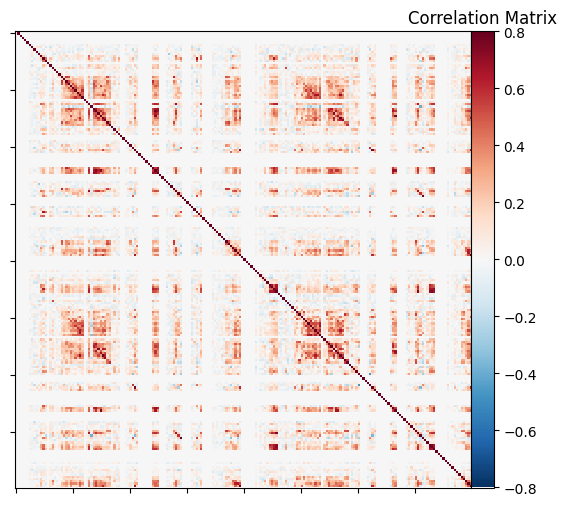

<Figure size 1500x800 with 0 Axes>

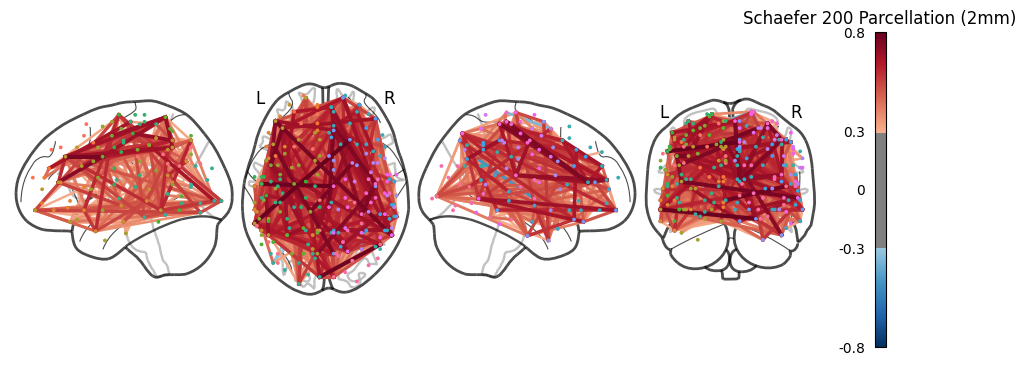


Connectivity Statistics:
Mean absolute connectivity: 0.061
Max positive connectivity: 0.792
Max negative connectivity: -0.471

Strongest Positive Connections:
ROI 7networks_RH_DorsAttn_TempOcc_4 <-> ROI 7networks_LH_Vis_Striate_2: 0.776
ROI 7networks_RH_Limbic_OFC_2 <-> ROI 7networks_LH_Cont_Temp: 0.791
ROI 7networks_LH_Cont_Temp <-> ROI 7networks_RH_Limbic_OFC_2: 0.791
ROI 7networks_LH_SomMot_12 <-> ROI 7networks_RH_SomMot_5: 0.792
ROI 7networks_RH_SomMot_5 <-> ROI 7networks_LH_SomMot_12: 0.792


In [53]:
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load your correlation matrix
matrix_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
correlation_matrix = np.load(matrix_path)

# Load coordinates with the correct 2mm path
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

# Generate random colors
node_colors = sns.color_palette('husl', n_colors=200)

# Create two separate figures for better control
# Figure 1: Matrix
plt.figure(figsize=(10, 8))
plotting.plot_matrix(
    correlation_matrix,
    colorbar=True,
    vmax=0.8,
    vmin=-0.8,
    cmap='RdBu_r'
)
plt.title('Correlation Matrix')
plt.show()

# Figure 2: Brain Connectome
plt.figure(figsize=(15, 8))
plotting.plot_connectome(
    correlation_matrix,
    coords,
    edge_threshold='95%',
    node_size=3,
    node_color=node_colors,
    display_mode='lzry',
    edge_vmin=-0.8,
    edge_vmax=0.8,
    colorbar=True,
    edge_cmap='RdBu_r'
)
plt.title('Schaefer 200 Parcellation (2mm)')
plt.show()

# Print statistics
print("\nConnectivity Statistics:")
np.fill_diagonal(correlation_matrix, 0)  # Remove diagonal for stats
print(f"Mean absolute connectivity: {np.mean(np.abs(correlation_matrix)):.3f}")
print(f"Max positive connectivity: {np.max(correlation_matrix):.3f}")
print(f"Max negative connectivity: {np.min(correlation_matrix):.3f}")

# Show strongest connections
print("\nStrongest Positive Connections:")
top_positive = np.unravel_index(np.argsort(correlation_matrix.ravel())[-5:], correlation_matrix.shape)
for i, j in zip(top_positive[0], top_positive[1]):
    if i != j:  # Skip diagonal
        print(f"ROI {coords_df['ROI Name'][i]} <-> ROI {coords_df['ROI Name'][j]}: {correlation_matrix[i,j]:.3f}")

<Figure size 1500x800 with 0 Axes>

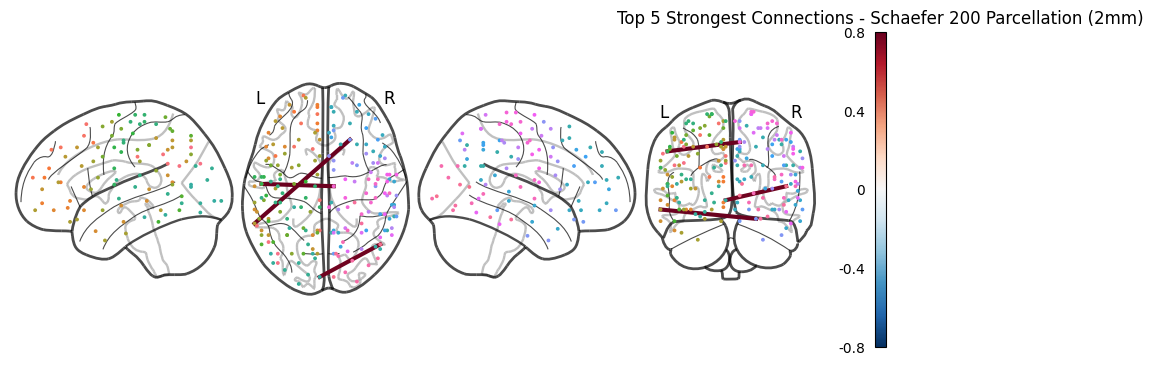


Top 5 Strongest Connections:
ROI 7networks_RH_DorsAttn_TempOcc_4 <-> ROI 7networks_LH_Vis_Striate_2: 0.776
ROI 7networks_LH_Cont_Temp <-> ROI 7networks_RH_Limbic_OFC_2: 0.791
ROI 7networks_RH_Limbic_OFC_2 <-> ROI 7networks_LH_Cont_Temp: 0.791
ROI 7networks_RH_SomMot_5 <-> ROI 7networks_LH_SomMot_12: 0.792
ROI 7networks_LH_SomMot_12 <-> ROI 7networks_RH_SomMot_5: 0.792


In [54]:
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load your correlation matrix
matrix_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
correlation_matrix = np.load(matrix_path)

# Load coordinates with the correct 2mm path
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

# Generate random colors
node_colors = sns.color_palette('husl', n_colors=200)

# Create a mask for the top 5 connections
# First, make a copy and set diagonal to 0
matrix_for_mask = correlation_matrix.copy()
np.fill_diagonal(matrix_for_mask, 0)

# Find the indices of the top 5 strongest connections
top_5_flat_indices = np.argsort(np.abs(matrix_for_mask.ravel()))[-5:]
top_5_indices = np.unravel_index(top_5_flat_indices, matrix_for_mask.shape)

# Create a mask matrix of zeros
mask_matrix = np.zeros_like(correlation_matrix)
mask_matrix[top_5_indices] = correlation_matrix[top_5_indices]

# Make it symmetric (since the connections are undirected)
mask_matrix = np.maximum(mask_matrix, mask_matrix.T)

# Plot the top 5 connections
plt.figure(figsize=(15, 8))
plotting.plot_connectome(
    mask_matrix,
    coords,
    node_size=3,
    node_color=node_colors,
    display_mode='lzry',
    edge_vmin=-0.8,
    edge_vmax=0.8,
    colorbar=True,
    edge_cmap='RdBu_r'
)
plt.title('Top 5 Strongest Connections - Schaefer 200 Parcellation (2mm)')
plt.show()

# Print the top 5 connections
print("\nTop 5 Strongest Connections:")
for idx in range(5):
    i, j = top_5_indices[0][idx], top_5_indices[1][idx]
    if i != j:  # Skip diagonal
        print(f"ROI {coords_df['ROI Name'][i]} <-> ROI {coords_df['ROI Name'][j]}: {correlation_matrix[i,j]:.3f}")

In [ ]:
# load data
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def load_matrices_simple(results_dir, n_rois=200):
    """
    Simple function to load and average connectivity matrices
    
    Parameters:
    results_dir (str): Directory containing connectivity matrices
    n_rois (int): Number of ROIs (200 or 400)
    
    Returns:
    tuple: (averaged_matrix, region_labels)
    """
    # Load all individual matrices
    #matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}/*_connectivity_matrix.npy')
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices/*[!glasser]_connectivity_matrix.npy') #!glasser to exclude glasser matrices
    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}/connectivity_matrices_{n_rois}/")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    # Load and average matrices
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    # Create simple region labels
    region_labels = [f"Region_{i+1}" for i in range(n_rois)]
    
    return matrix, region_labels


# Set up paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Create figures directory if it doesn't exist
#os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load 200 ROI data
matrix, region_labels = load_matrices_simple(results_dir, n_rois=200)

# Now you can proceed with the visualization functions

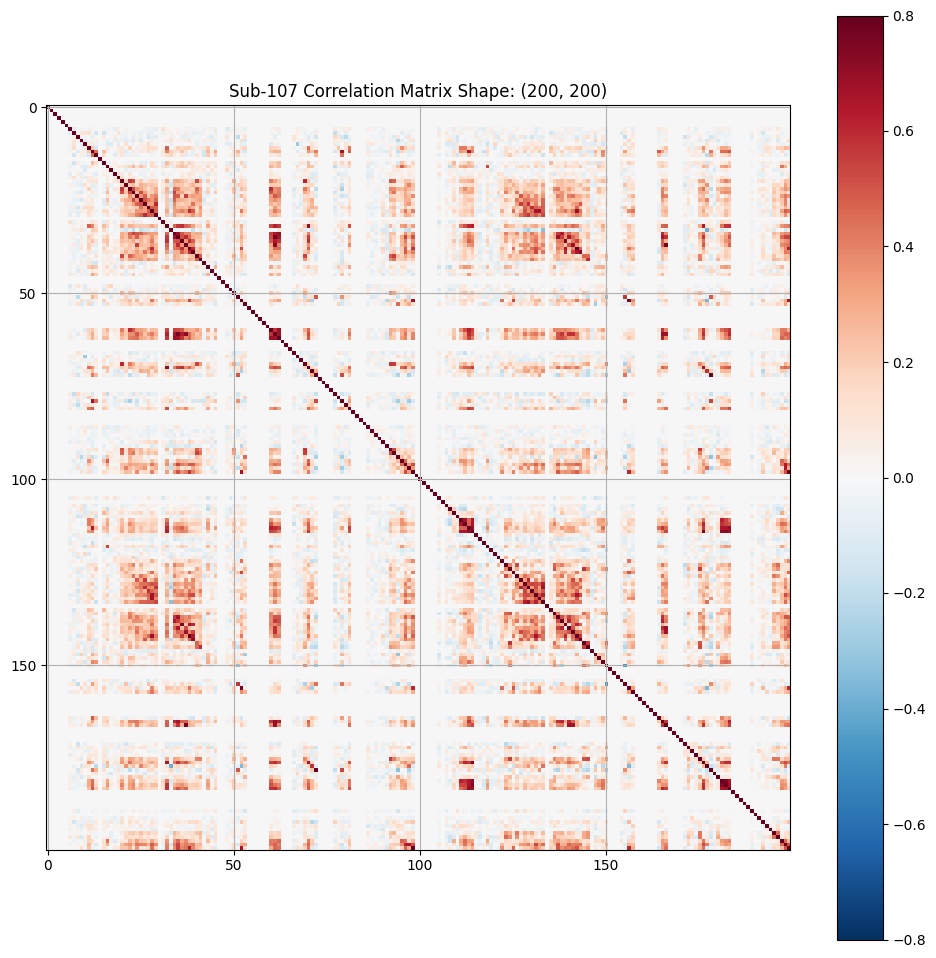


Connectivity Statistics for Sub-107:
Number of regions: 200
Total possible connections: 19900
Connections above 80th percentile threshold (0.000): 10685
Percentage of strong connections: 53.69%


<Figure size 1000x1000 with 0 Axes>

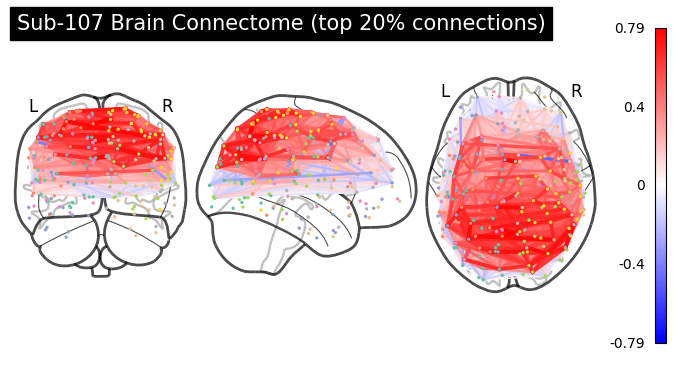

In [8]:
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

# Load your connectivity matrix
matrix_file = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
matrix = np.load(matrix_file)

# Load the Schaefer atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
labels = [label.decode() if isinstance(label, bytes) else label for label in atlas.labels]

# Get the coordinates for each region
coords = plotting.find_parcellation_cut_coords(atlas.maps)

# Plot matrix dimensions with clear ticks
plt.figure(figsize=(12, 12))
plt.imshow(matrix, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
plt.colorbar()

# Add ticks every 50 positions
tick_spacing = 50
ticks = np.arange(0, matrix.shape[0], tick_spacing)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)

plt.title(f"Sub-107 Correlation Matrix Shape: {matrix.shape}")
plt.grid(True)
plt.show()

# Create connectome plot
plt.figure(figsize=(10, 10))
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold="0%",  # Keep top 20% of connections
    node_color='auto',
    node_size=2,
    title="Sub-107 Brain Connectome (top 20% connections)",
    colorbar=True
)

# Create an interactive visualization
view = plotting.view_connectome(
    matrix,
    coords,
    edge_threshold="0%",
    node_color='auto',
    node_size=2
)

# Open the interactive plot in a browser
view.open_in_browser()

# Print some statistics about the connectivity
total_connections = (len(matrix) * (len(matrix) - 1)) / 2  # Total possible connections
threshold = np.percentile(np.abs(matrix[np.triu_indices_from(matrix, k=1)]), 20)
strong_connections = np.sum(np.abs(matrix) > threshold) / 2  # Divide by 2 to not count connections twice

print(f"\nConnectivity Statistics for Sub-107:")
print(f"Number of regions: {len(matrix)}")
print(f"Total possible connections: {int(total_connections)}")
print(f"Connections above 80th percentile threshold ({threshold:.3f}): {int(strong_connections)}")
print(f"Percentage of strong connections: {(strong_connections/total_connections)*100:.2f}%")

plt.show()

Coordinate Ranges:
X range: -61.0 to 63.7
Y range: -96.8 to 64.5
Z range: -38.6 to 70.3


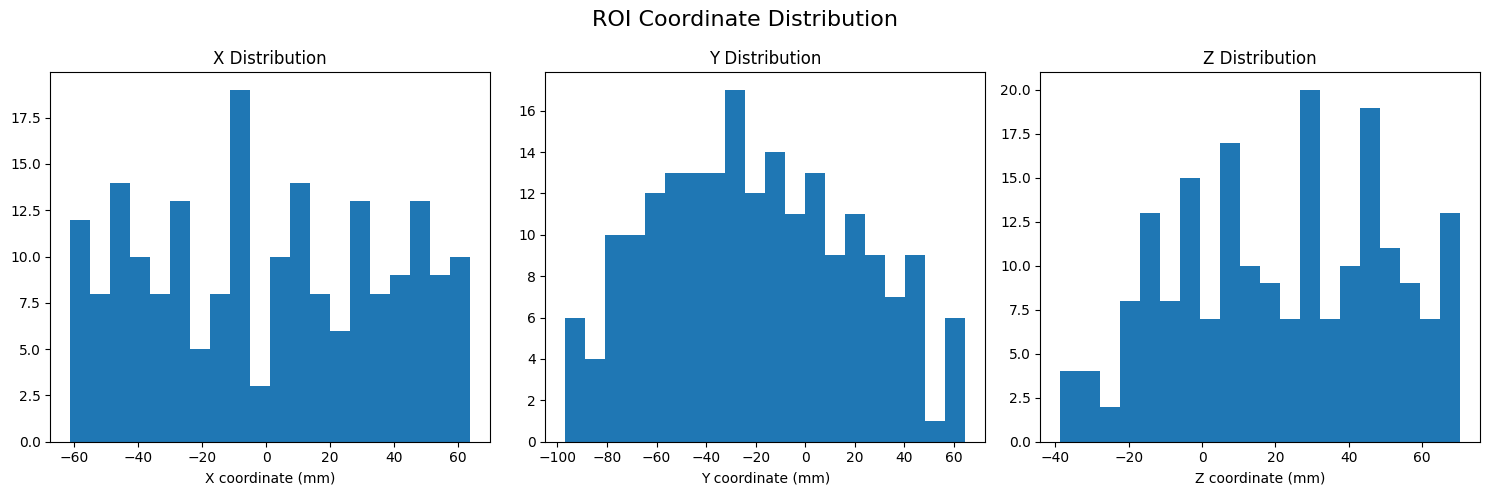

/tmp/ipykernel_20368/2474018034.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


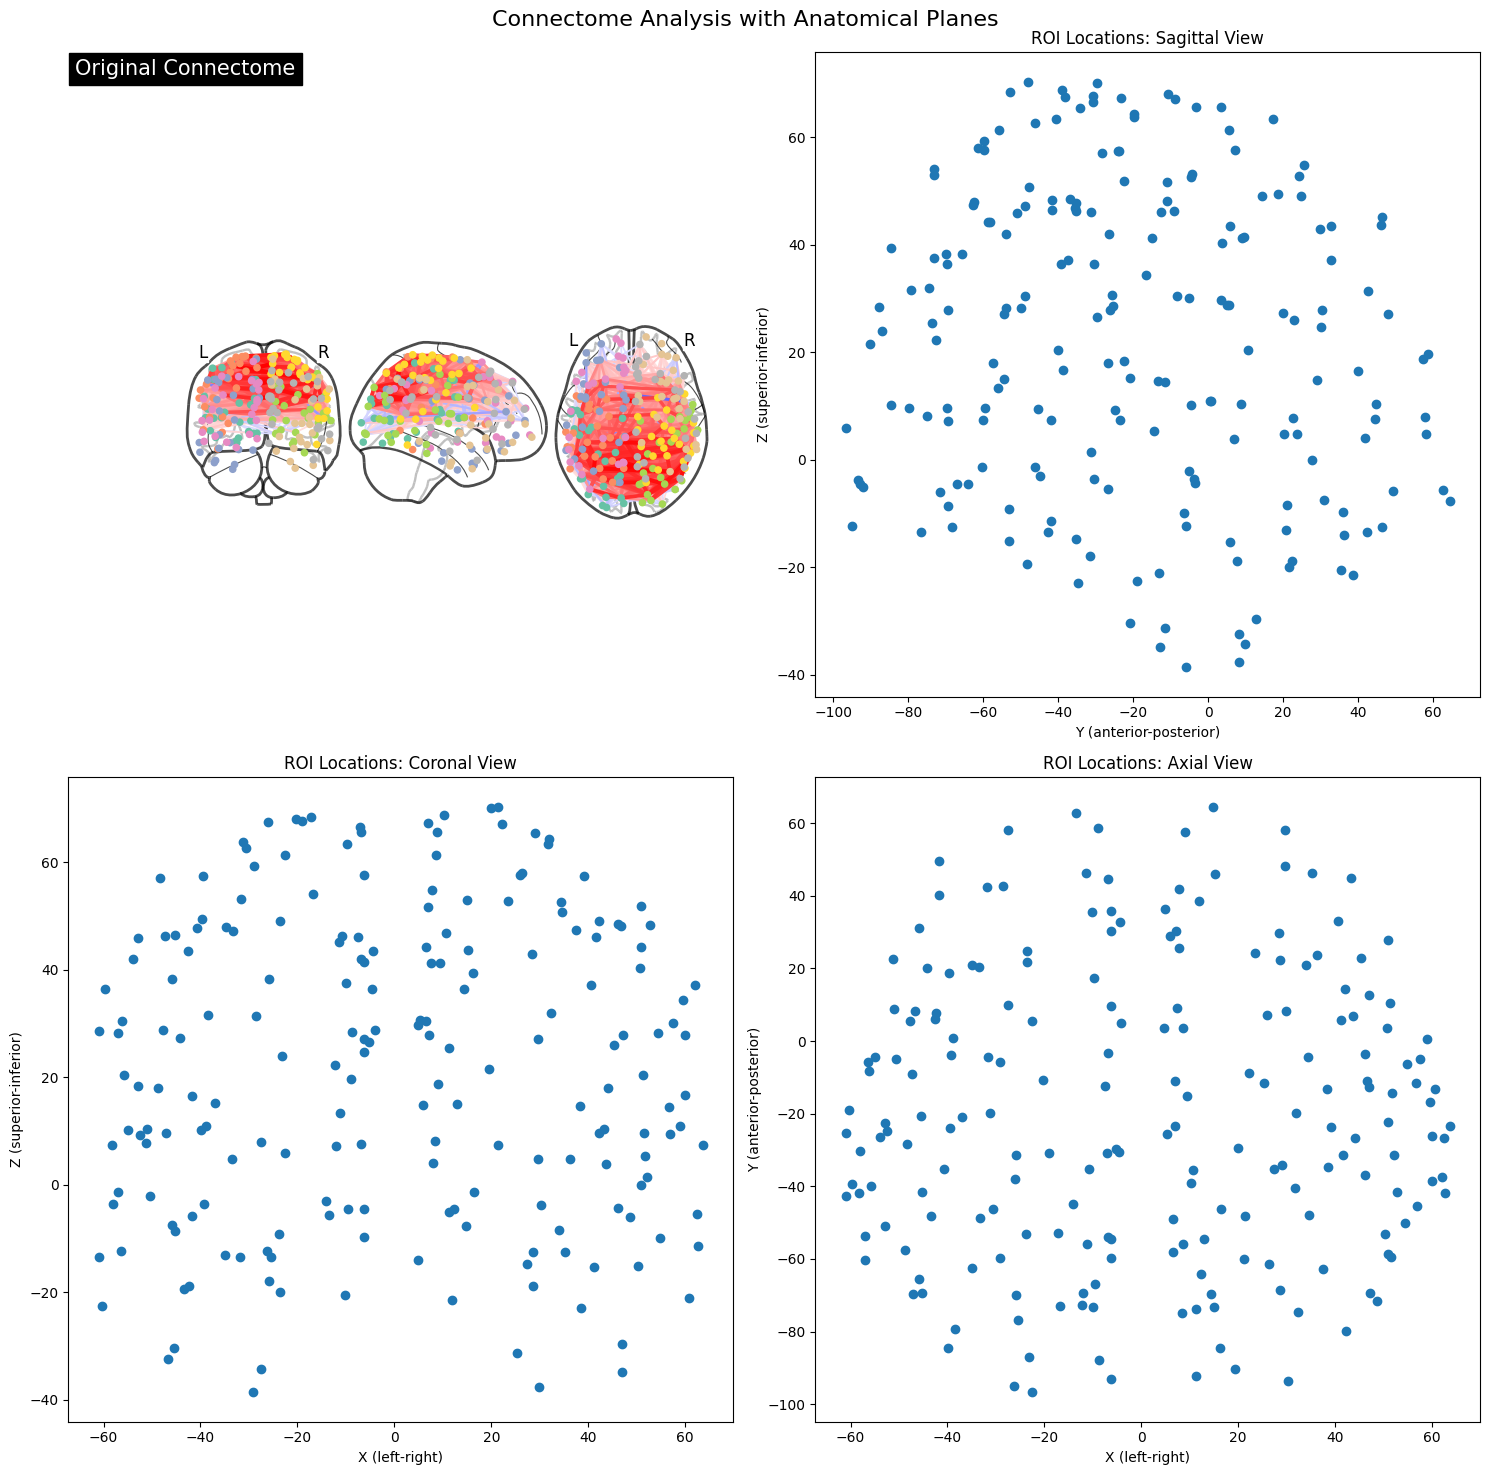


Atlas Coverage Analysis:
Total voxels in atlas: 902629
Non-zero voxels: 132032
Coverage percentage: 14.63%

Z-axis coverage range: 11 to 76 (out of 91)


In [17]:
# Cell 1: Import libraries
import numpy as np
from nilearn import datasets, plotting, image
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure
import nibabel as nib
import os

# Cell 2: Load and check data
subject = "sub-107"
matrix_file = f"/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/{subject}_connectivity_matrix_standard.npy"

# Load matrix
matrix = np.load(matrix_file)

# Load atlas with explicit checking
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_img = nib.load(atlas.maps)

# Get and inspect coordinates
coords = plotting.find_parcellation_cut_coords(atlas.maps)

# Print coordinate ranges for inspection
print("Coordinate Ranges:")
print(f"X range: {coords[:, 0].min():.1f} to {coords[:, 0].max():.1f}")
print(f"Y range: {coords[:, 1].min():.1f} to {coords[:, 1].max():.1f}")
print(f"Z range: {coords[:, 2].min():.1f} to {coords[:, 2].max():.1f}")

# Cell 3: Create validation visualization
def plot_coordinate_distribution(coords):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('ROI Coordinate Distribution', fontsize=16)
    
    # Plot distribution of coordinates in each dimension
    axes[0].hist(coords[:, 0], bins=20)
    axes[0].set_title('X Distribution')
    axes[0].set_xlabel('X coordinate (mm)')
    
    axes[1].hist(coords[:, 1], bins=20)
    axes[1].set_title('Y Distribution')
    axes[1].set_xlabel('Y coordinate (mm)')
    
    axes[2].hist(coords[:, 2], bins=20)
    axes[2].set_title('Z Distribution')
    axes[2].set_xlabel('Z coordinate (mm)')
    
    plt.tight_layout()
    return fig

# Plot coordinate distributions
plot_coordinate_distribution(coords)
plt.show()

# Cell 4: Create modified connectome visualization
def plot_connectome_with_planes(matrix, coords):
    """Plot connectome with additional anatomical plane indicators"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Connectome Analysis with Anatomical Planes', fontsize=16)
    
    # Original connectome
    plotting.plot_connectome(
        matrix,
        coords,
        edge_threshold='80%',
        node_color='auto',
        node_size=20,
        display_mode='ortho',
        axes=axes[0, 0],
        title="Original Connectome"
    )
    
    # Scatter plots of ROI locations
    # Sagittal view (Y-Z)
    axes[0, 1].scatter(coords[:, 1], coords[:, 2])
    axes[0, 1].set_xlabel('Y (anterior-posterior)')
    axes[0, 1].set_ylabel('Z (superior-inferior)')
    axes[0, 1].set_title('ROI Locations: Sagittal View')
    
    # Coronal view (X-Z)
    axes[1, 0].scatter(coords[:, 0], coords[:, 2])
    axes[1, 0].set_xlabel('X (left-right)')
    axes[1, 0].set_ylabel('Z (superior-inferior)')
    axes[1, 0].set_title('ROI Locations: Coronal View')
    
    # Axial view (X-Y)
    axes[1, 1].scatter(coords[:, 0], coords[:, 1])
    axes[1, 1].set_xlabel('X (left-right)')
    axes[1, 1].set_ylabel('Y (anterior-posterior)')
    axes[1, 1].set_title('ROI Locations: Axial View')
    
    plt.tight_layout()
    return fig

# Create validation plots
plot_connectome_with_planes(matrix, coords)
plt.show()

# Cell 5: Check atlas coverage
def check_atlas_coverage():
    """Check the coverage of the atlas in the brain"""
    atlas_data = atlas_img.get_fdata()
    
    # Get non-zero voxel coordinates
    nonzero_coords = np.where(atlas_data > 0)
    
    print("\nAtlas Coverage Analysis:")
    print(f"Total voxels in atlas: {np.prod(atlas_data.shape)}")
    print(f"Non-zero voxels: {len(nonzero_coords[0])}")
    print(f"Coverage percentage: {(len(nonzero_coords[0])/np.prod(atlas_data.shape))*100:.2f}%")
    
    # Check z-axis coverage
    z_coverage = np.any(atlas_data > 0, axis=(0,1))
    z_range = np.where(z_coverage)[0]
    print(f"\nZ-axis coverage range: {z_range[0]} to {z_range[-1]} (out of {atlas_data.shape[2]})")

# Run atlas coverage check
check_atlas_coverage()

/tmp/ipykernel_20368/2227941079.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


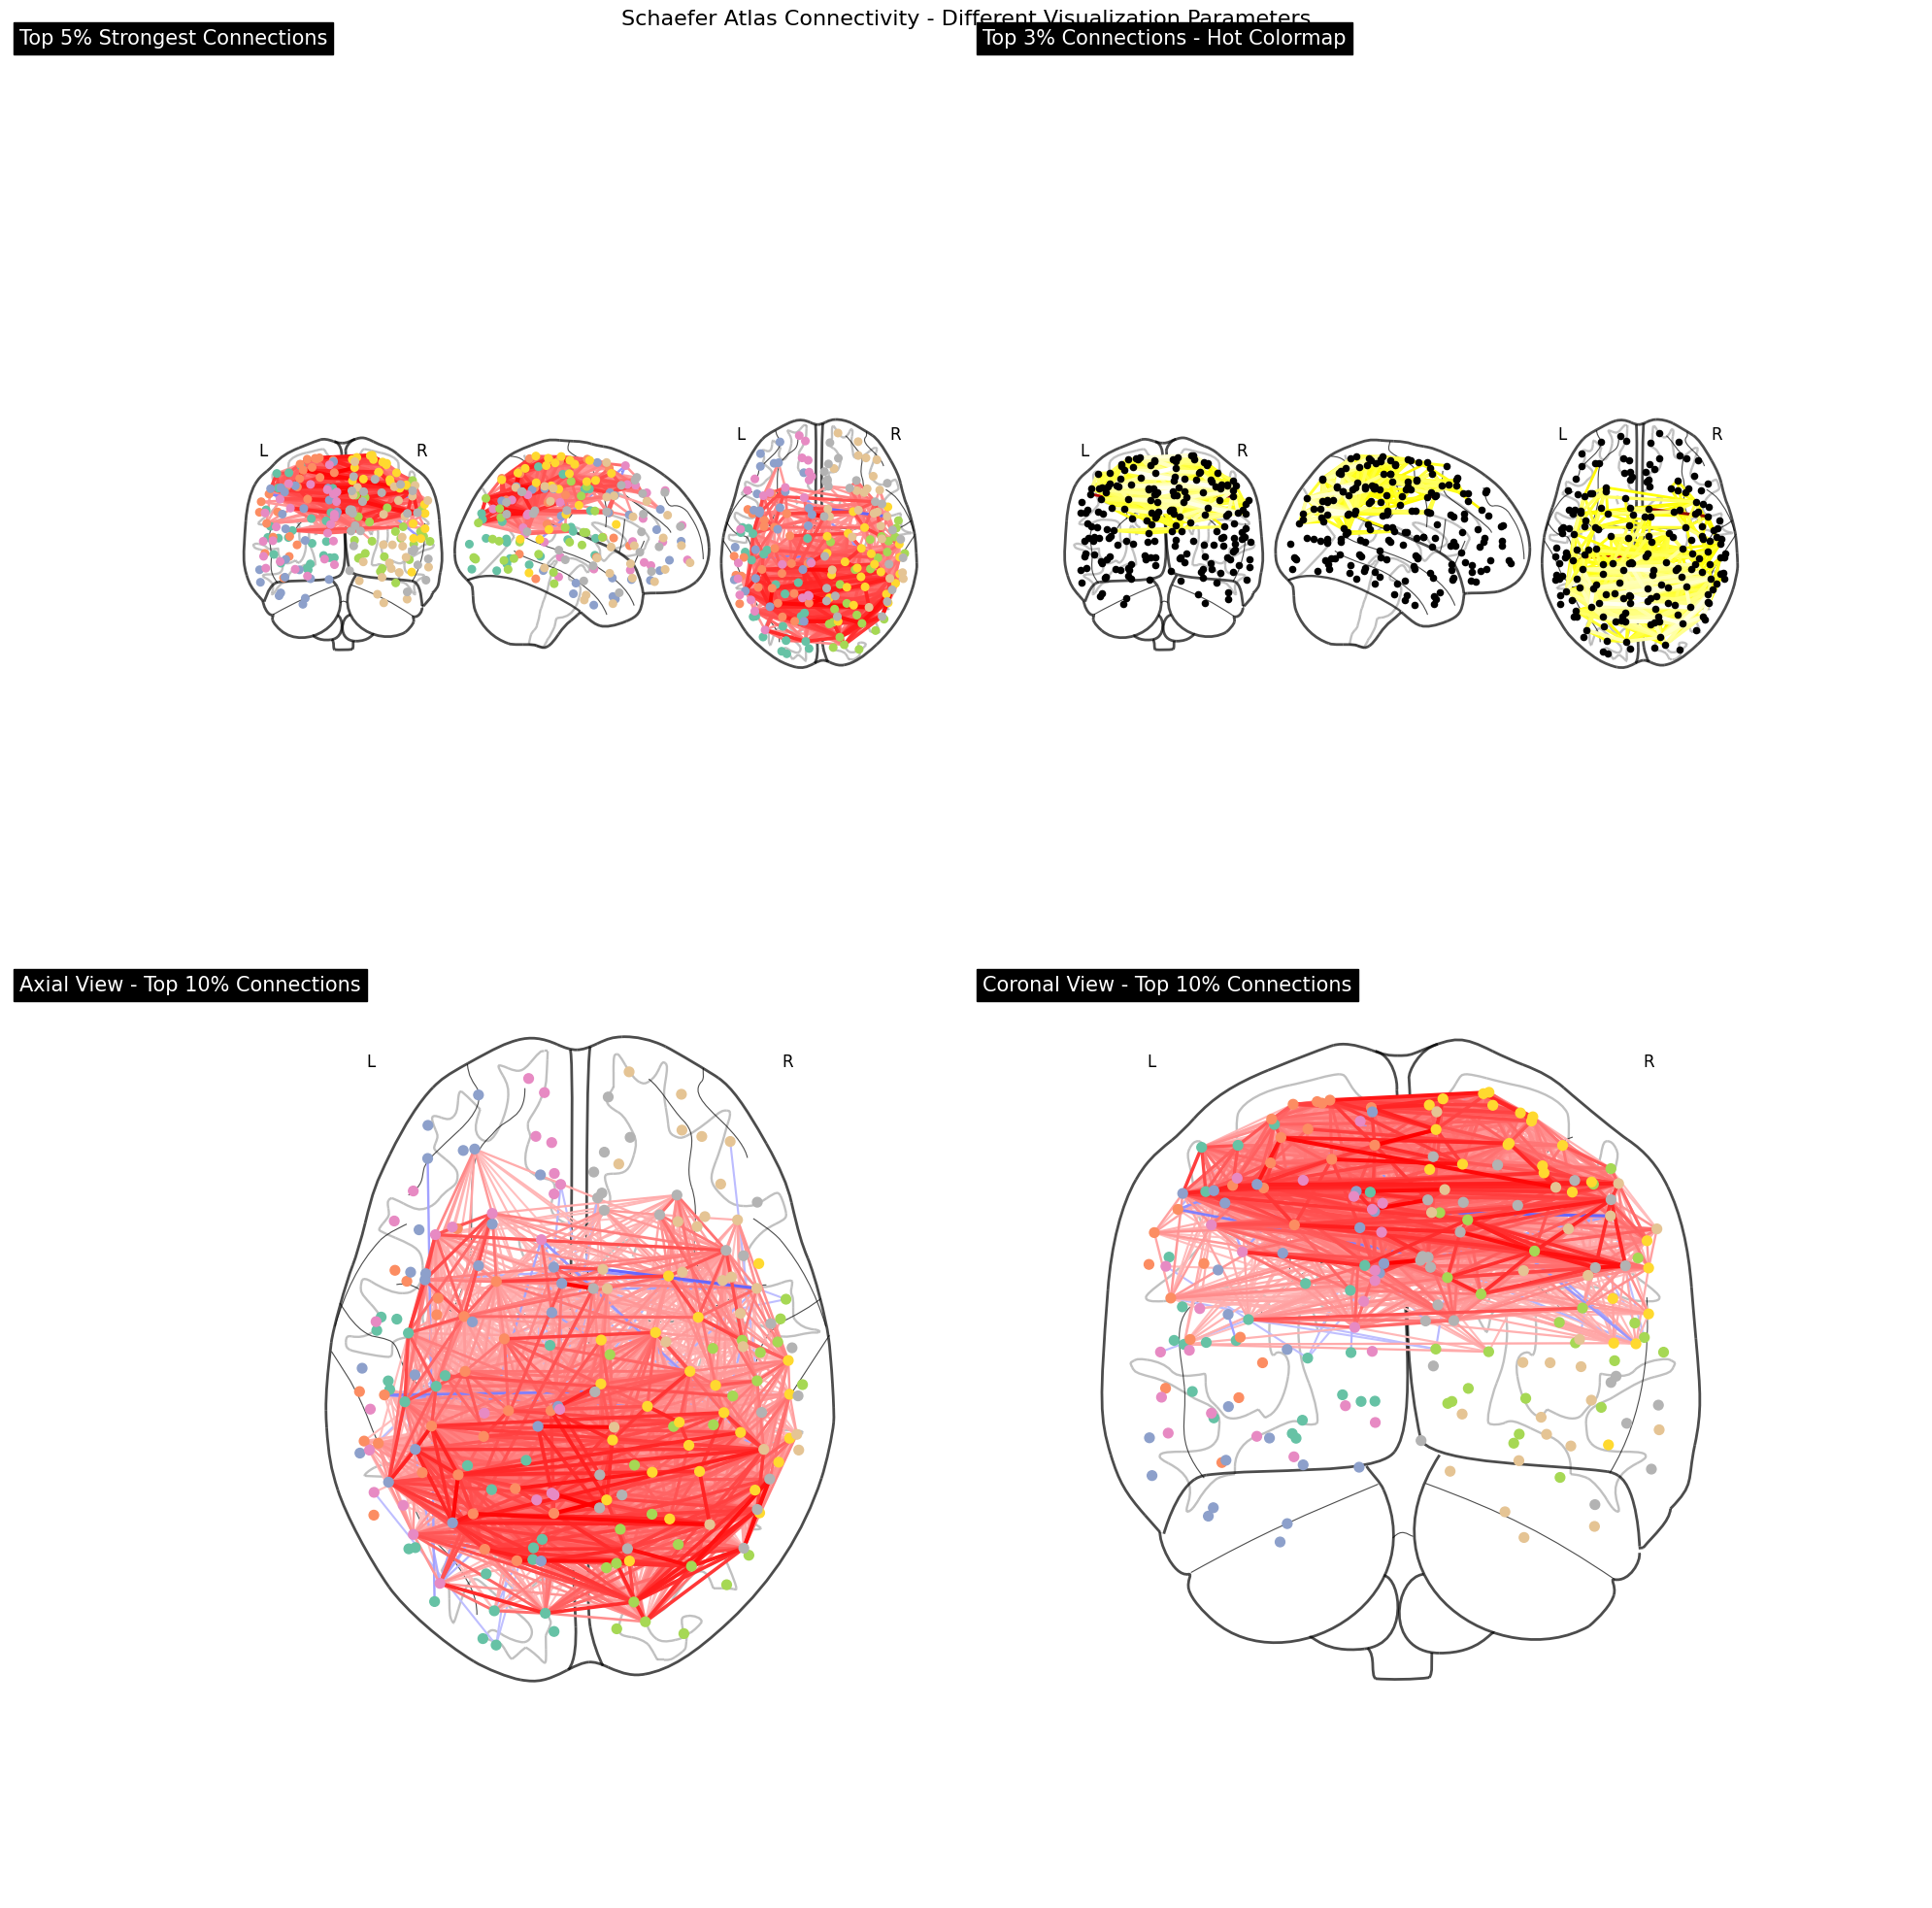


Connection Threshold Analysis:

At 90.0% threshold:
Correlation threshold value: 0.194
Number of connections shown: 2090
Percentage of total possible connections: 10.50%

At 95.0% threshold:
Correlation threshold value: 0.297
Number of connections shown: 1095
Percentage of total possible connections: 5.50%

At 97.0% threshold:
Correlation threshold value: 0.369
Number of connections shown: 697
Percentage of total possible connections: 3.50%


In [27]:
# Cell 1: Improved connectome visualization
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt

# Load your connectivity matrix
matrix_file = "/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy"
matrix = np.load(matrix_file)

# Load Schaefer atlas
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
coords = plotting.find_parcellation_cut_coords(schaefer_atlas.maps)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Schaefer Atlas Connectivity - Different Visualization Parameters', fontsize=16)

# Plot 1: Standard view with different threshold
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold='95%',  # Show only top 5% strongest connections
    node_color='auto',
    node_size=30,  # Larger nodes
    display_mode='ortho',
    axes=axes[0, 0],
    title="Top 5% Strongest Connections"
)

# Plot 2: Different colormap and edge threshold
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold='97%',  # Even more selective
    edge_cmap='hot',  # Different colormap
    node_color='k',  # Black nodes
    node_size=20,
    display_mode='ortho',
    axes=axes[0, 1],
    title="Top 3% Connections - Hot Colormap"
)

# Plot 3: Single view with more connections
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold='90%',
    node_color='auto',
    node_size=50,  # Even larger nodes
    display_mode='z',  # Only axial view
    axes=axes[1, 0],
    title="Axial View - Top 10% Connections"
)

# Plot 4: Another single view
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold='90%',
    node_color='auto',
    node_size=50,
    display_mode='y',  # Coronal view
    axes=axes[1, 1],
    title="Coronal View - Top 10% Connections"
)

plt.tight_layout()
plt.show()

# Print some statistics about the connections being shown
thresholds = [0.90, 0.95, 0.97]
print("\nConnection Threshold Analysis:")
for thresh in thresholds:
    thresh_value = np.percentile(np.abs(matrix[np.triu_indices_from(matrix, k=1)]), 
                               thresh * 100)
    n_connections = np.sum(np.abs(matrix) > thresh_value) // 2  # Divide by 2 because matrix is symmetric
    print(f"\nAt {thresh*100}% threshold:")
    print(f"Correlation threshold value: {thresh_value:.3f}")
    print(f"Number of connections shown: {n_connections}")
    print(f"Percentage of total possible connections: {(n_connections/(len(matrix)*(len(matrix)-1)/2))*100:.2f}%")

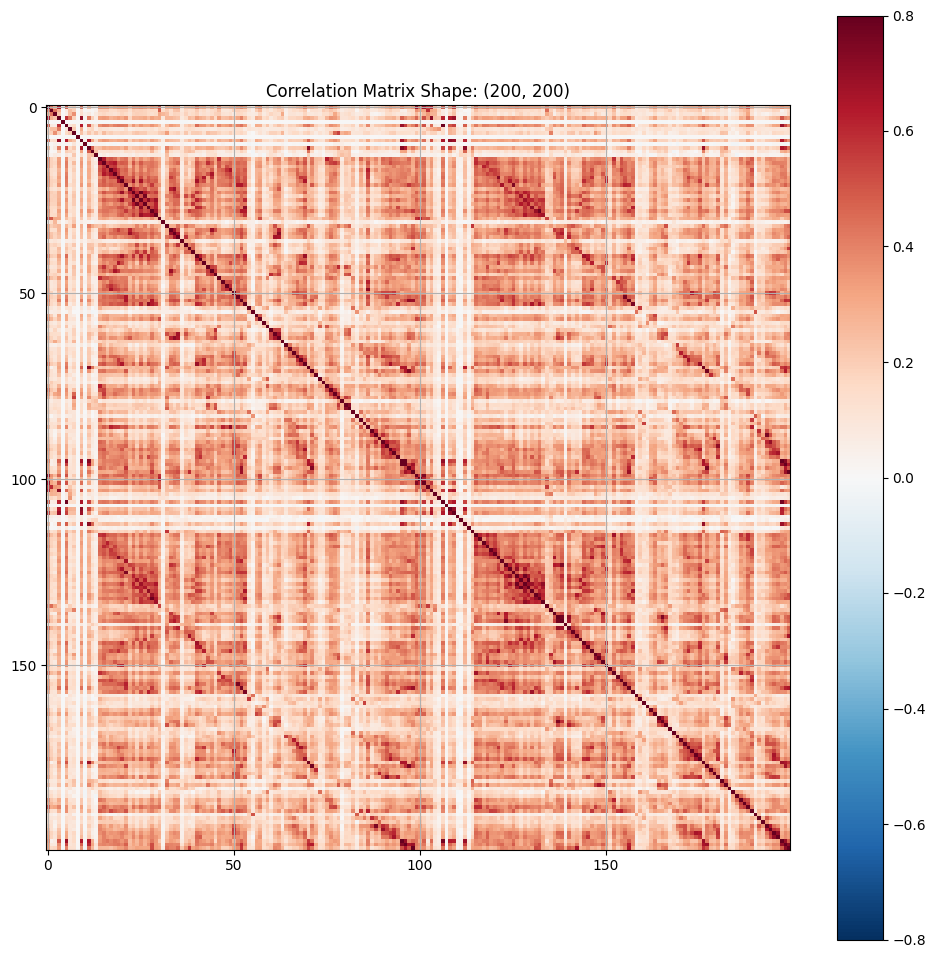


Connectivity Statistics:
Number of regions: 200
Total possible connections: 19900
Connections above 80th percentile threshold (0.366): 4080
Percentage of strong connections: 20.50%


<Figure size 1000x1000 with 0 Axes>

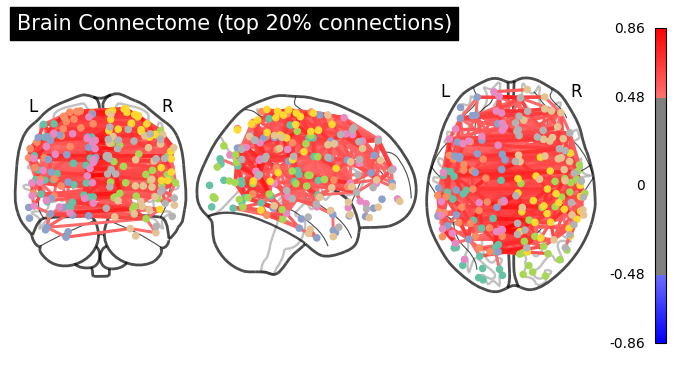

In [ ]:
#nilearn plotting
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

# Load the Schaefer atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
labels = [label.decode() if isinstance(label, bytes) else label for label in atlas.labels]

# Get the coordinates for each region
coords = plotting.find_parcellation_cut_coords(atlas.maps)

# Plot matrix dimensions with clear ticks
plt.figure(figsize=(12, 12))
plt.imshow(matrix, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
plt.colorbar()

# Add ticks every 50 positions
tick_spacing = 50
ticks = np.arange(0, matrix.shape[0], tick_spacing)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)

plt.title(f"Correlation Matrix Shape: {matrix.shape}")
plt.grid(True)
plt.show()

# Create connectome plot
plt.figure(figsize=(10, 10))
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold="80%",  # Keep top 20% of connections
    node_color='auto',
    node_size=20,
    title="Brain Connectome (top 20% connections)",
    colorbar=True
)

# Create an interactive visualization
view = plotting.view_connectome(
    matrix,
    coords,
    edge_threshold="80%",
    node_color='auto',
    node_size=20
)

# Open the interactive plot in a browser
view.open_in_browser()

# Print some statistics about the connectivity
total_connections = (len(matrix) * (len(matrix) - 1)) / 2  # Total possible connections
threshold = np.percentile(np.abs(matrix[np.triu_indices_from(matrix, k=1)]), 80)
strong_connections = np.sum(np.abs(matrix) > threshold) / 2  # Divide by 2 to not count connections twice

print(f"\nConnectivity Statistics:")
print(f"Number of regions: {len(matrix)}")
print(f"Total possible connections: {int(total_connections)}")
print(f"Connections above 80th percentile threshold ({threshold:.3f}): {int(strong_connections)}")
print(f"Percentage of strong connections: {(strong_connections/total_connections)*100:.2f}%")

plt.show()

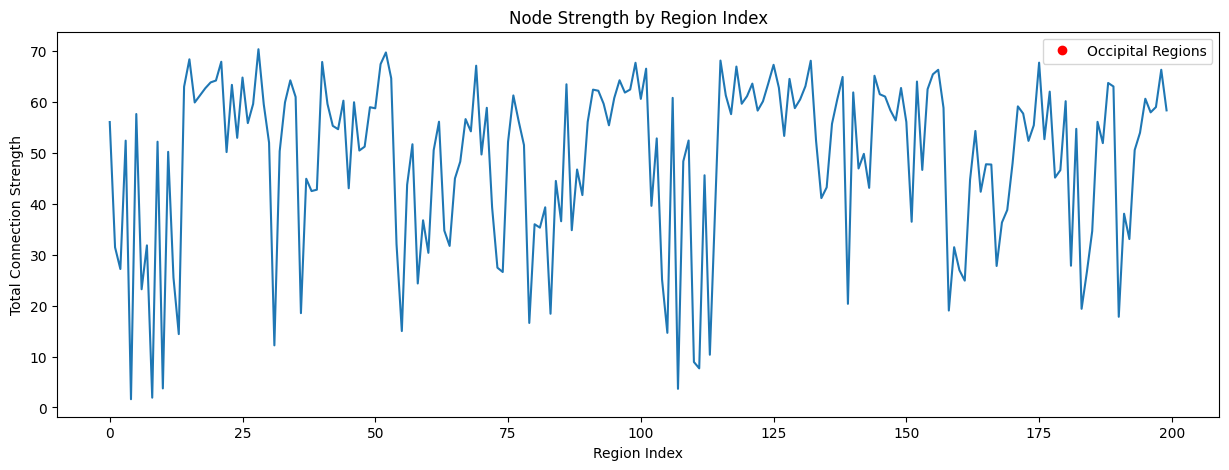

In [21]:
# Add regional connectivity strength analysis
node_strength = np.sum(np.abs(matrix), axis=0)

# Plot strength by region
plt.figure(figsize=(15, 5))
plt.plot(node_strength)
plt.title("Node Strength by Region Index")
plt.xlabel("Region Index")
plt.ylabel("Total Connection Strength")

# Add markers for occipital regions
plt.plot(occipital_indices, node_strength[occipital_indices], 'ro', label='Occipital Regions')
plt.legend()
plt.show()

Occipital connectivity stats:
Number of occipital regions: 0
Mean connectivity: nan
% of zero values: nan%
% of NaN values: nan%


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_20368/3235755903.py:9: RuntimeWarning: invalid value encountered in scalar divide
  print(f"% of zero values: {np.sum(occipital_connectivity == 0) / occipital_connectivity.size * 100}%")
/tmp/ipykernel_20368/3235755903.py:10: RuntimeWarning: invalid value encountered in scalar divide
  print(f"% of NaN values: {np.sum(np.isnan(occipital_connectivity)) / occipital_connectivity.size * 100}%")
/tmp/ipykernel_20368/3235755903.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(occipital_connectivity, cmap='RdBu_r')
/tmp/ipykernel_

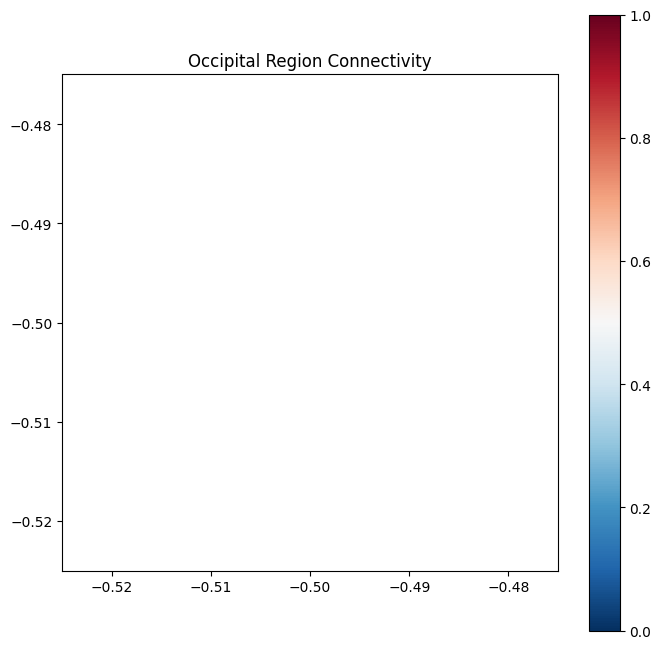

In [19]:
# Add these checks to your script
# Check for NaN or zero values in occipital regions
occipital_indices = [i for i, label in enumerate(labels) if 'Visual' in label]
occipital_connectivity = matrix[occipital_indices][:, occipital_indices]

print("Occipital connectivity stats:")
print(f"Number of occipital regions: {len(occipital_indices)}")
print(f"Mean connectivity: {np.mean(occipital_connectivity)}")
print(f"% of zero values: {np.sum(occipital_connectivity == 0) / occipital_connectivity.size * 100}%")
print(f"% of NaN values: {np.sum(np.isnan(occipital_connectivity)) / occipital_connectivity.size * 100}%")

# Visualize just the occipital subnetwork
plt.figure(figsize=(8, 8))
plt.imshow(occipital_connectivity, cmap='RdBu_r')
plt.title("Occipital Region Connectivity")
plt.colorbar()
plt.show()

In [23]:
# Print the first few labels to see their format
print("Sample of atlas labels:")
for i, label in enumerate(labels[:10]):
    print(f"{i}: {label}")

# Print unique network names in the labels
unique_networks = set()
for label in labels:
    # Split the label and add the network name
    parts = label.split('_')
    if len(parts) > 1:
        unique_networks.add(parts[1])  # Usually network name is the second part

print("\nUnique networks found in labels:")
for network in sorted(unique_networks):
    print(network)

# Count regions per network
network_counts = {}
for label in labels:
    parts = label.split('_')
    if len(parts) > 1:
        network = parts[1]
        network_counts[network] = network_counts.get(network, 0) + 1

print("\nNumber of regions per network:")
for network, count in network_counts.items():
    print(f"{network}: {count} regions")

Sample of atlas labels:
0: 7Networks_LH_Vis_1
1: 7Networks_LH_Vis_2
2: 7Networks_LH_Vis_3
3: 7Networks_LH_Vis_4
4: 7Networks_LH_Vis_5
5: 7Networks_LH_Vis_6
6: 7Networks_LH_Vis_7
7: 7Networks_LH_Vis_8
8: 7Networks_LH_Vis_9
9: 7Networks_LH_Vis_10

Unique networks found in labels:
LH
RH

Number of regions per network:
LH: 100 regions
RH: 100 regions



Number of visual regions found: 29

Visual region labels:
7Networks_LH_Vis_1
7Networks_LH_Vis_2
7Networks_LH_Vis_3
7Networks_LH_Vis_4
7Networks_LH_Vis_5
7Networks_LH_Vis_6
7Networks_LH_Vis_7
7Networks_LH_Vis_8
7Networks_LH_Vis_9
7Networks_LH_Vis_10
7Networks_LH_Vis_11
7Networks_LH_Vis_12
7Networks_LH_Vis_13
7Networks_LH_Vis_14
7Networks_RH_Vis_1
7Networks_RH_Vis_2
7Networks_RH_Vis_3
7Networks_RH_Vis_4
7Networks_RH_Vis_5
7Networks_RH_Vis_6
7Networks_RH_Vis_7
7Networks_RH_Vis_8
7Networks_RH_Vis_9
7Networks_RH_Vis_10
7Networks_RH_Vis_11
7Networks_RH_Vis_12
7Networks_RH_Vis_13
7Networks_RH_Vis_14
7Networks_RH_Vis_15

Visual network connectivity stats:
Mean connectivity: 0.201
Min connectivity: -0.041
Max connectivity: 1.000


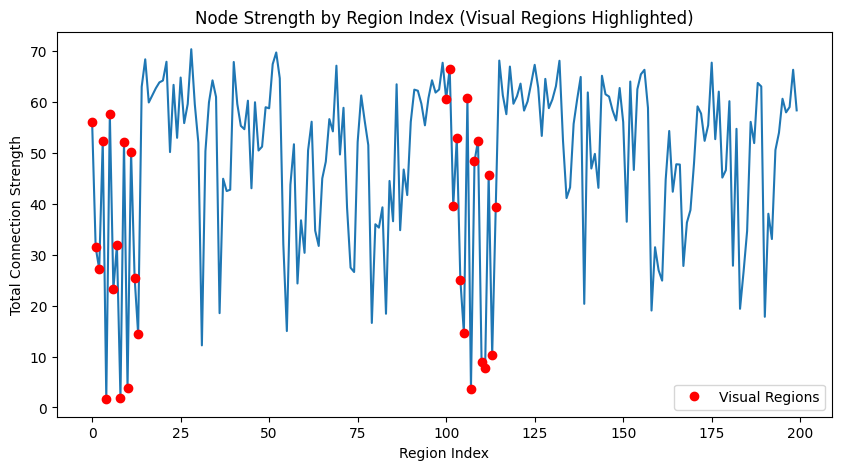

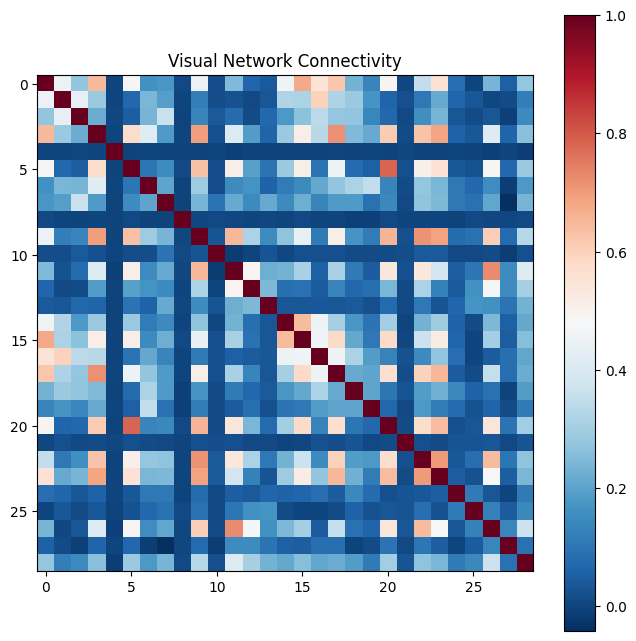

In [24]:
# Correct identification of visual regions
occipital_indices = [i for i, label in enumerate(labels) if '_Vis_' in label]
print(f"\nNumber of visual regions found: {len(occipital_indices)}")

# Print the actual visual region labels to verify
print("\nVisual region labels:")
for idx in occipital_indices:
    print(f"{labels[idx]}")

# Calculate connectivity stats for visual regions
if len(occipital_indices) > 0:
    occipital_connectivity = matrix[occipital_indices][:, occipital_indices]
    print("\nVisual network connectivity stats:")
    print(f"Mean connectivity: {np.mean(occipital_connectivity):.3f}")
    print(f"Min connectivity: {np.min(occipital_connectivity):.3f}")
    print(f"Max connectivity: {np.max(occipital_connectivity):.3f}")
    
    # Plot node strength specifically for visual regions
    plt.figure(figsize=(10, 5))
    plt.plot(node_strength)
    plt.plot(occipital_indices, node_strength[occipital_indices], 'ro', label='Visual Regions')
    plt.title("Node Strength by Region Index (Visual Regions Highlighted)")
    plt.xlabel("Region Index")
    plt.ylabel("Total Connection Strength")
    plt.legend()
    plt.show()

    # Visualize the visual network connectivity matrix
    plt.figure(figsize=(8, 8))
    plt.imshow(occipital_connectivity, cmap='RdBu_r')
    plt.title("Visual Network Connectivity")
    plt.colorbar()
    plt.show()

In [26]:
# Calculate mean connectivity for each network
networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
for network in networks:
    network_indices = [i for i, label in enumerate(labels) if f'_{network}_' in label]
    if network_indices:
        network_connectivity = matrix[network_indices][:, network_indices]
        print(f"{network} network mean connectivity: {np.mean(network_connectivity):.3f}")

Vis network mean connectivity: 0.201
SomMot network mean connectivity: 0.465
DorsAttn network mean connectivity: 0.322
SalVentAttn network mean connectivity: 0.393
Limbic network mean connectivity: 0.260
Cont network mean connectivity: 0.297
Default network mean connectivity: 0.265
